In [8]:
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import xarray as xr

## Preprocessing j_ratio

In [24]:
ds = xr.open_mfdataset("../data/elb_j_paraovrperp_event0*.nc", combine="nested")
df = pl.read_csv("../data/elb_orb_event0*.csv")

# assign the data with coordinates
j_ratio = ds["j"]
j_ratio = j_ratio.assign_coords(
    L=("time", df["L"]), time=pd.to_datetime(j_ratio.time.values, unit="s")
)

(16, 501)


In [25]:
# filter whistler mode waves
print(j_ratio.shape)
j_ratio_EMIC = j_ratio.sel(
    time=(j_ratio.max("energy") != j_ratio.isel(energy=0)).values
)
print(j_ratio_EMIC.shape)

(16, 501)
(16, 201)


In [27]:
df = (
    j_ratio_EMIC.groupby_bins("L", bins=[4.5, 5.5, 6.5], labels=[5, 6])
    .mean("time")
    .to_dataframe()
)

In [28]:
df.to_csv("../data/Daa_a_j.csv")

## Plotting

In [2]:
ds = xr.open_mfdataset("../data/elb_j_paraovrperp_event03.nc", combine="nested")
df = pl.read_csv("../data/elb_orb_event03.csv")

j_ratio = ds["j"]
j_ratio = j_ratio.assign_coords(
    L=("time", df["L"]), time=pd.to_datetime(j_ratio.time.values, unit="s")
)

In [17]:
from pytplot import options, store_data, tplot

tplot_refwidth = "128mm"
tplot_refheight = "27mm"

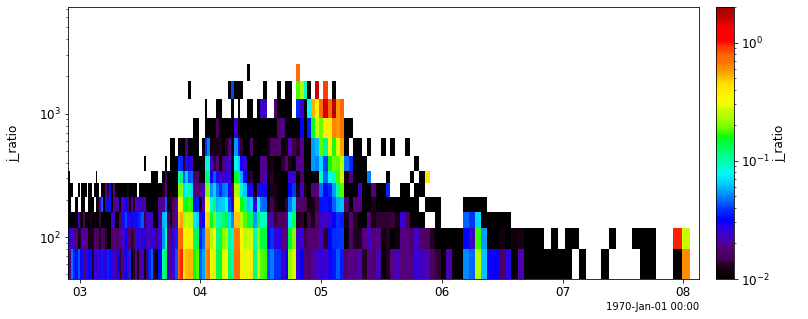

In [18]:
store_data(
    "j_ratio",
    data={"x": j_ratio.L.values, "y": j_ratio.transpose(), "v": j_ratio.energy.values},
)

options("j_ratio", "spec", True)
options("j_ratio", "ylog", True)
options("j_ratio", "zlog", True)
options("j_ratio", "zrange", [1e-2, 2])
tplot("j_ratio")

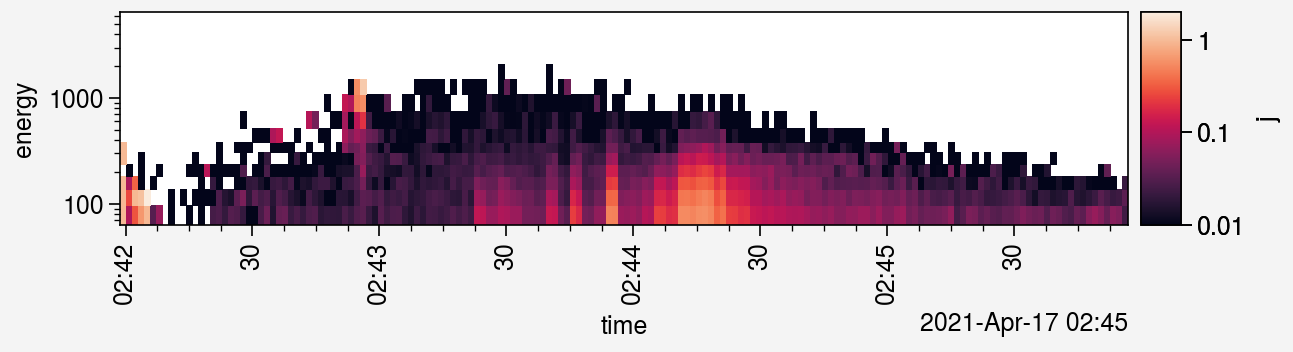

In [47]:
fig, axs = pplt.subplots(
    refwidth=tplot_refwidth,
    refheight=tplot_refheight,
)

vmin = 1e-2

axs.pcolormesh(
    j_ratio, norm="log", vmin=vmin, vmax=2, colorbar="r", discrete=False, cmap="rocket"
)
axs.format(yscale="log")

## Results

In [2]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "notebook"])

In [3]:
%load_ext rpy2.ipython

In [4]:
import rpy2
import rpy2_arrow.arrow as pyra
from rpy2.robjects.packages import importr

# | code-summary: helper functions to convert between `python` and `R` dataframes

base = importr("base")

conv_pl = rpy2.robjects.conversion.Converter(
    "Pandas to pyarrow", template=pyra.converter
)


@conv_pl.py2rpy.register(pl.DataFrame)
def py2rpy_pandas(dataf: pl.DataFrame):
    pa_tbl = dataf.to_arrow()
    return base.as_data_frame(pa_tbl)
    # return pyra.converter.py2rpy(pa_tbl) # NOTE: not working for ggplot2


conv_pl = rpy2.ipython.rmagic.converter + conv_pl

In [69]:
%%R
library(ggplot2)
library(ggpubr)
library(viridis)

library(glue)
library(arrow)

Loading required package: viridisLite


### Maximum equatorial pitch-angle $\alpha_{max,EMIC}$ 

In [10]:
alpha_max_EMIC = pd.read_csv("../data/alpha_max_EMIC.csv")

#### Python version

`altair` plot does not support math symbols and could not deal with missing values. So `matplotlib` is used to plot the results.

In [15]:
%%markdown

import altair as alt
import vegafusion as vf
vf.enable(row_limit = int(1e6))

alt.Chart(alpha_max_EMIC).mark_rect().encode(
    alt.X('energy'),
    alt.Y('c1'),
    alt.Color('alpha'),
    column='L_bins:N'
)



import altair as alt
import vegafusion as vf
vf.enable(row_limit = int(1e6))

alt.Chart(alpha_max_EMIC).mark_rect().encode(
    alt.X('energy'),
    alt.Y('c1'),
    alt.Color('alpha'),
    column='L_bins:N'
)


/var/folders/tg/rfd0nr_970s3mv1fspgvkkxm0000gn/T/ipykernel_34482/953899478.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to accommodate colorbar


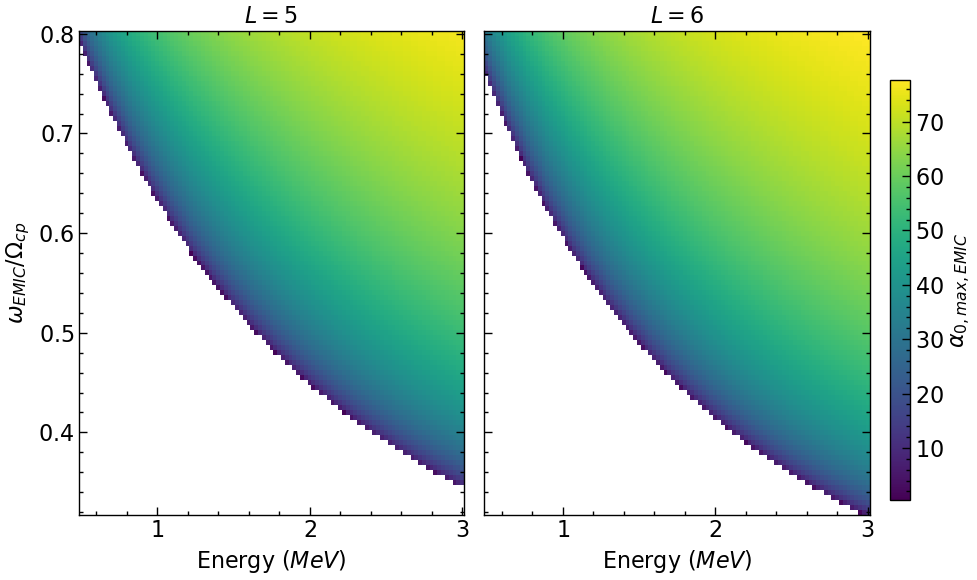

In [20]:
# Calculate the global min and max values
global_min = alpha_max_EMIC["alpha"].min()
global_max = alpha_max_EMIC["alpha"].max()

# Sample data (replace with your alpha_max_EMIC data import)
# alpha_max_EMIC = pd.read_csv('path_to_data.csv')
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(alpha_max_EMIC["L_bins"].unique()),
    figsize=(10, 6),
    sharey=True,
    sharex=True,
)

for ax, (label, group) in zip(axes, alpha_max_EMIC.groupby("L_bins")):
    # Sort the group to ensure proper plotting order
    group_sorted = group.sort_values(by=["c1", "energy"])
    pivot_data = group_sorted.pivot(index="c1", columns="energy", values="alpha")

    X, Y = np.meshgrid(pivot_data.columns, pivot_data.index)
    c = ax.pcolormesh(X, Y, pivot_data.values, vmin=global_min, vmax=global_max)

    # Set the title for each subplot
    ax.set_title(rf"$L={label}$")
    ax.set_xlabel(r"Energy ($MeV$)")
    if ax == axes[0]:  # Only set the ylabel for the first subplot
        ax.set_ylabel(r"$\omega_{EMIC}/\Omega_{cp}$")


# Display the colorbar on the right
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cbar = fig.colorbar(c, cax=cbar_ax)
cbar.set_label(r"$\alpha_{0,max,EMIC}$")  # Set label for colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to accommodate colorbar
plt.show()
fig.savefig("../figures/alpha_max_EMIC.png", bbox_inches="tight")
fig.savefig("../figures/alpha_max_EMIC.pdf", bbox_inches="tight")